# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [73]:
import numpy as np
import astropy as ap
np.random.seed(10)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

# # read in the dat data file using pandas df

sn1 = pd.read_csv("PS1_PS1MD_PSc000098.snana.dat", delim_whitespace=True)
sn2 = pd.read_csv("PS1_PS1MD_PSc000174.snana.dat", delim_whitespace=True)

In [4]:
F1g = np.asarray(sn1[(sn1['FLT'] == 'g')].loc[:,"FLUXCAL"])
F1r = np.asarray(sn1[(sn1['FLT'] == 'r')].loc[:,"FLUXCAL"])
F1i = np.asarray(sn1[(sn1['FLT'] == 'i')].loc[:,"FLUXCAL"])
F1z = np.asarray(sn1[(sn1['FLT'] == 'z')].loc[:,"FLUXCAL"])
t1g = np.asarray(sn1[(sn1['FLT'] == 'g')].loc[:,"MJD"])
t1r = np.asarray(sn1[(sn1['FLT'] == 'r')].loc[:,"MJD"])
t1i = np.asarray(sn1[(sn1['FLT'] == 'i')].loc[:,"MJD"])
t1z = np.asarray(sn1[(sn1['FLT'] == 'z')].loc[:,"MJD"])
Ferr1g = np.asarray(sn1[(sn1['FLT'] == 'g')].loc[:,"FLUXCALERR"])
Ferr1r = np.asarray(sn1[(sn1['FLT'] == 'r')].loc[:,"FLUXCALERR"])
Ferr1i = np.asarray(sn1[(sn1['FLT'] == 'i')].loc[:,"FLUXCALERR"])
Ferr1z = np.asarray(sn1[(sn1['FLT'] == 'z')].loc[:,"FLUXCALERR"])

F2g = np.asarray(sn2[(sn2['FLT'] == 'g')].loc[:,"FLUXCAL"])
F2r = np.asarray(sn2[(sn2['FLT'] == 'r')].loc[:,"FLUXCAL"])
F2i = np.asarray(sn2[(sn2['FLT'] == 'i')].loc[:,"FLUXCAL"])
F2z = np.asarray(sn2[(sn2['FLT'] == 'z')].loc[:,"FLUXCAL"])
t2g = np.asarray(sn2[(sn2['FLT'] == 'g')].loc[:,"MJD"])
t2r = np.asarray(sn2[(sn2['FLT'] == 'r')].loc[:,"MJD"])
t2i = np.asarray(sn2[(sn2['FLT'] == 'i')].loc[:,"MJD"])
t2z = np.asarray(sn2[(sn2['FLT'] == 'z')].loc[:,"MJD"])
Ferr2g = np.asarray(sn2[(sn2['FLT'] == 'g')].loc[:,"FLUXCALERR"])
Ferr2r = np.asarray(sn2[(sn2['FLT'] == 'r')].loc[:,"FLUXCALERR"])
Ferr2i = np.asarray(sn2[(sn2['FLT'] == 'i')].loc[:,"FLUXCALERR"])
Ferr2z = np.asarray(sn2[(sn2['FLT'] == 'z')].loc[:,"FLUXCALERR"])



In [5]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# the likelihood function is the same as we write above, except now as a log
def model_start(theta, t):

    return (theta[0]+theta[3]*(t-theta[1]))/(1+np.exp(-(t-theta[1])/theta[2]))
    
def model_end(theta, t):
    t1=theta[4]+theta[1]
    return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))

def model(theta, t):
    fluxes = np.piecewise(t, [t < theta[4], t >= theta[4]], [lambda t: model_start(theta,t),lambda t: model_end(theta,t)])
    return fluxes

def log_likelihood(theta, t, f, err):
    
    # this is the residual
    dy = f - np.nan_to_num(model(theta,t))
    
    # you should write two log-likelihood terms to implement the sum in the above formula
    # as logL1 and logL2
    logL = dy**2/(2*err**2)
    
    # we have the sum of two PDFs that we took the log of
    # to do this when we write those PDFs itself as logs, we can use np.logaddexp
    return -.5*np.sum(logL)

def log_prior(theta,Fmax,tmin,tmax):
#     if 0<theta[0] and theta[0]<100*Fmax and tmin-50<theta[1] and theta[1]<tmax+300 and .01<theta[2] and theta[2]<50 and -Fmax/150<theta[3] and theta[3]<0 and 1<theta[5] and theta[5]<300:
#         probs = 0 
#     else:
#         probs = -np.inf
    
#     gauss_prob = np.log(((2/3)*(1/(5*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-5)/5)**2)) + 
#                  (1/3)*1/(30*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-60)/30)**2)))
#     return (probs+gauss_prob)
    if 5<theta[0] and theta[0]<50*Fmax:
        prob1 = np.log(1/(50*Fmax-5))
    else:
        prob1 = -np.inf
        
    if tmin-50<theta[1] and theta[1]<tmax:
        prob2 = np.log(1/((tmax)-(tmin-50)))
    else:
        prob2 = -np.inf
        
    if .01<theta[2] and theta[2]<50:
        prob3 = np.log(1/(50-.01))
    else:
        prob3 = -np.inf
        
    if -Fmax/150<theta[3] and theta[3]<0:
        prob4 = np.log(1/(Fmax/150))
    else:
        prob4 = -np.inf
        
    prob5 = np.log(((2/3)*(1/(5*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-5)/5)**2)) + 
            (1/3)*1/(30*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-60)/30)**2)))

    if 1<theta[5] and theta[5]<100:
        prob6 = np.log(1/(100-1))
    else:
        prob6 = -np.inf
    return prob1+prob2+prob3+prob4+prob5+prob6

def log_posterior(theta, t, f, err,Fmax, tmin, tmax):
    # posterior is product of likelihood and prior (or sum of log likelihoods)
#     print((log_prior(theta, Fmax,tmin,tmax)), (log_likelihood(theta, t, f, err)),theta)
    if not np.isfinite(log_likelihood(theta, t, f, err)):
        return -np.inf
    return np.nan_to_num(log_prior(theta, Fmax,tmin,tmax) + log_likelihood(theta, t, f, err))


In [6]:
def initialize_params(Fmax, tmin, tmax,nwalkers,ndim):
    # set theta as priors stated in Table 1

    starting_guesses = np.zeros((nwalkers, ndim))
    starting_guesses[:, 0] = np.random.uniform(5, 50*Fmax, nwalkers)
    starting_guesses[:, 1] = np.random.uniform(tmin-50, tmax, nwalkers)
    starting_guesses[:, 2] = np.random.uniform(.01, 50, nwalkers)
    starting_guesses[:, 3] = np.random.uniform(-Fmax/150, 0, nwalkers)
    starting_guesses[:, 4] = (2/3)*np.random.normal(5, 5, nwalkers)+(1/3)*np.random.normal(60, 30, nwalkers)
    starting_guesses[:, 5] = np.random.uniform(1, 100, nwalkers)
    return starting_guesses

# PS1_PS1MD_PSc000098, Filter G

In [7]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F1g)
tmin = min(t1g)
tmax = max(t1g)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)



In [8]:
import emcee

sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t1g, F1g, Ferr1g,Fmax,tmin,tmax])
_ =  sampler1.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [9]:
sample1 = sampler1.chain  # shape = (nwalkers, nsteps, ndim)
sample1 = sampler1.chain[:, nburn:, :].reshape(-1, ndim)

In [10]:
theta1 = np.median(sample1,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/1542796099.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


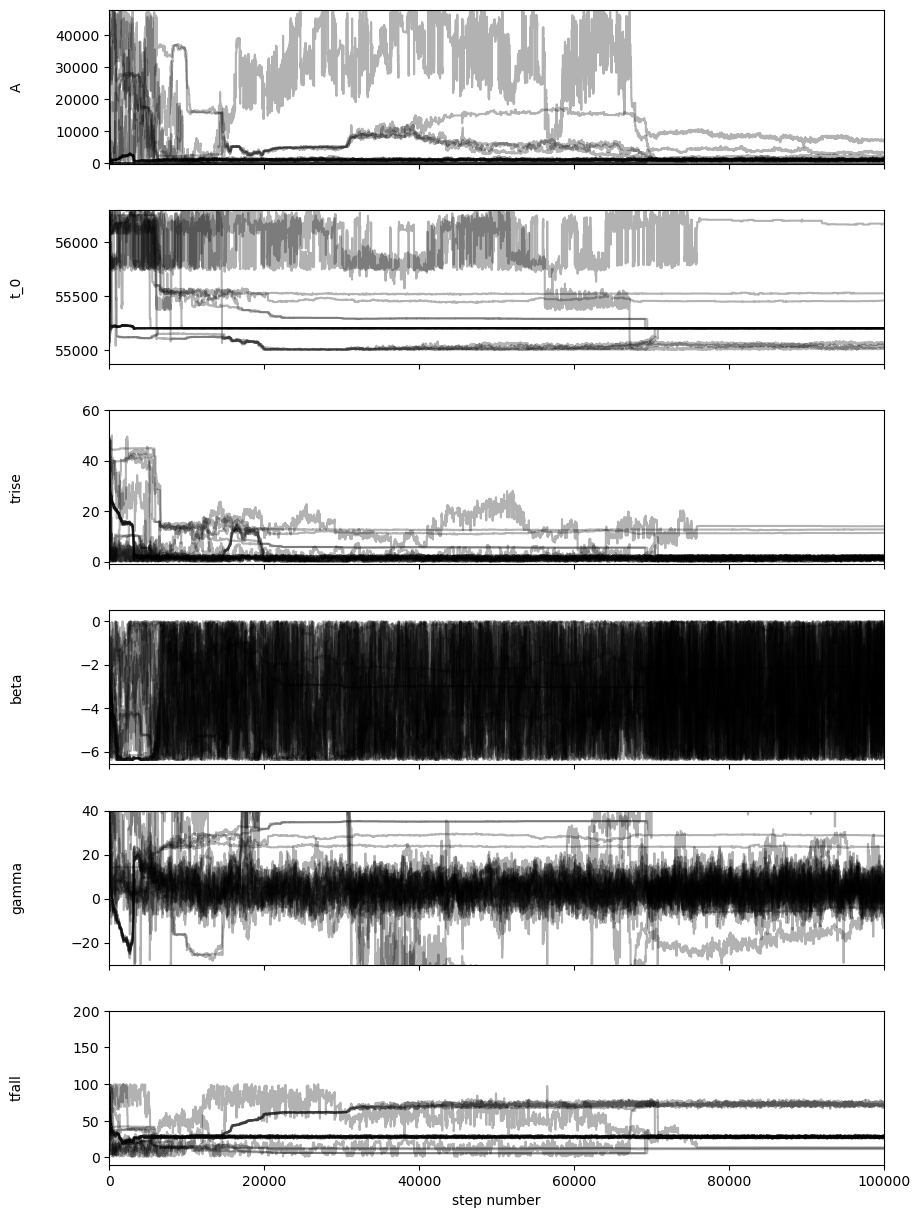

In [11]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples1 = sampler1.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples1[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

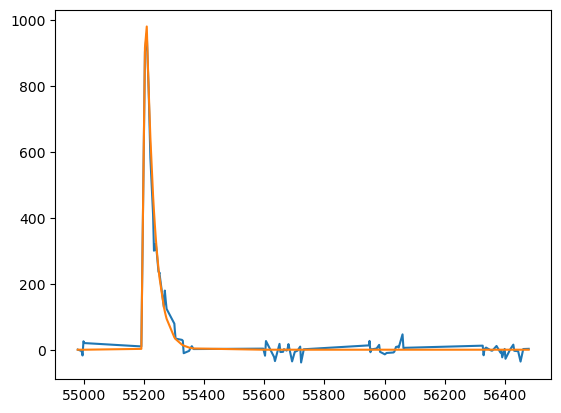

In [12]:
plt.plot(t1g,F1g)
plt.plot(t1g,model(theta1,t1g))

In [13]:
flat_samples1 = sampler1.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples1.shape)


(66660, 6)


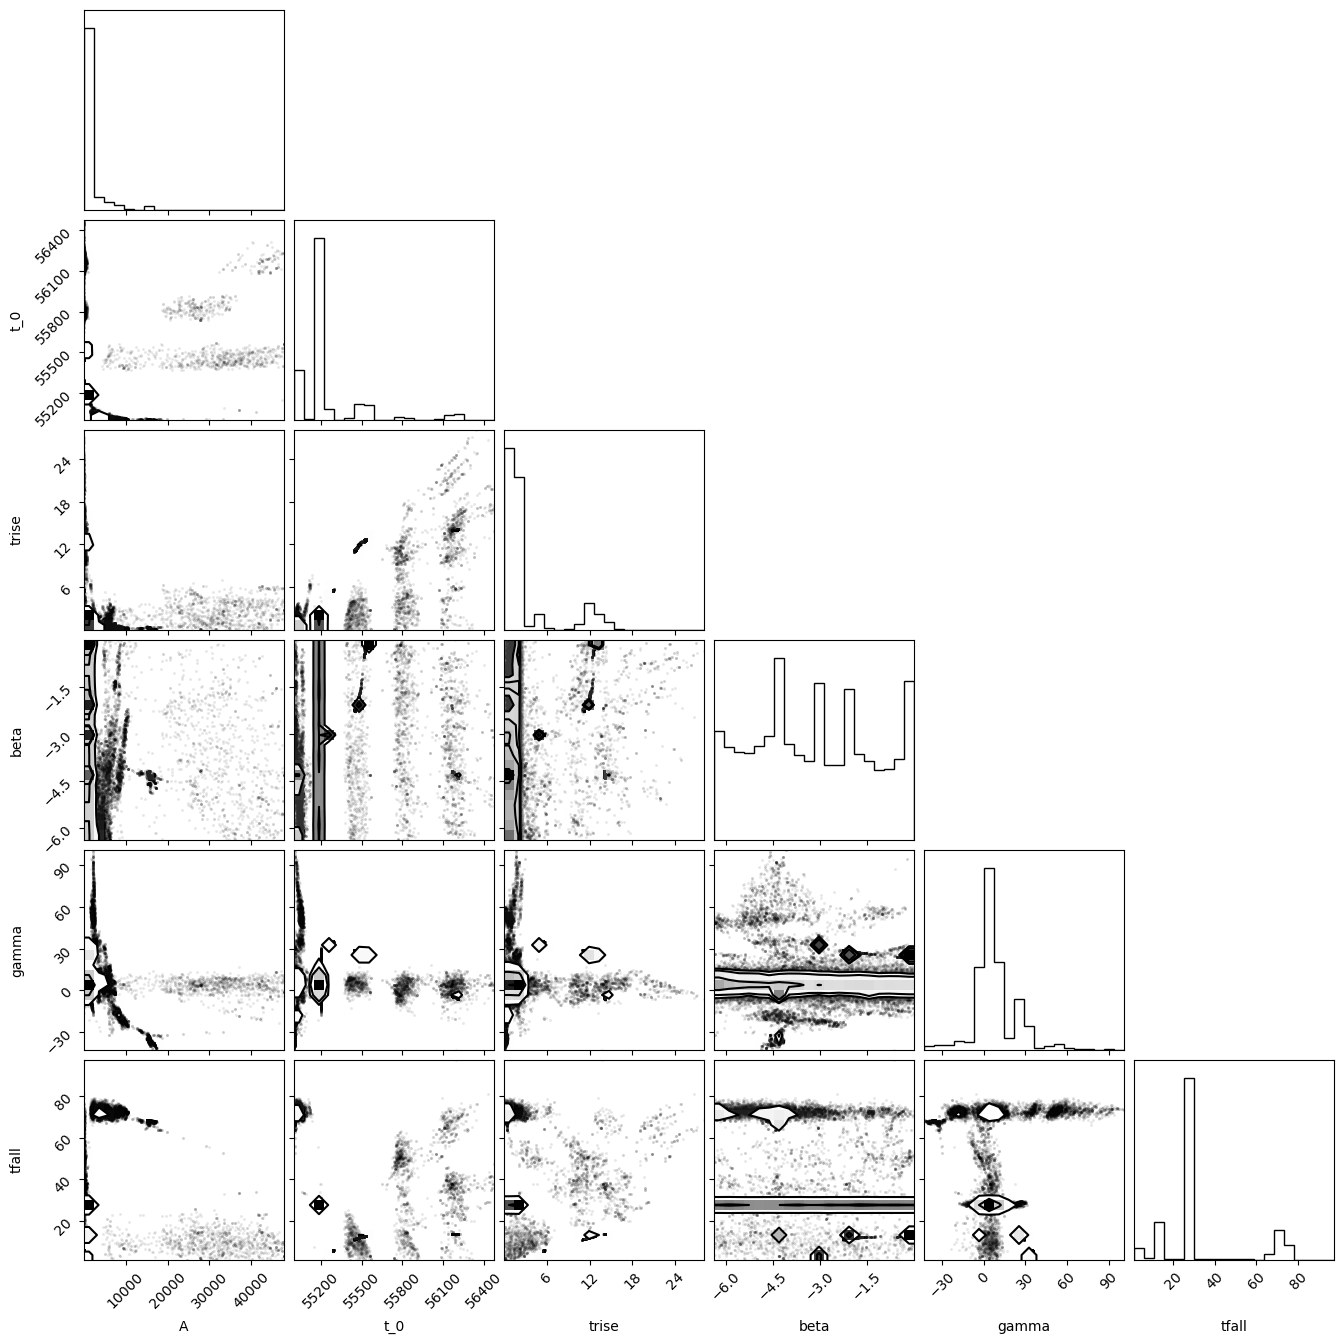

In [14]:
import corner

fig = corner.corner(flat_samples1, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000098, Filter R

In [16]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F1r)
tmin = min(t1r)
tmax = max(t1r)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t1r, F1r, Ferr1r,Fmax,tmin,tmax])
_ =  sampler2.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [17]:
sample2 = sampler2.chain  # shape = (nwalkers, nsteps, ndim)
sample2 = sampler2.chain[:, nburn:, :].reshape(-1, ndim)

In [18]:
theta2 = np.median(sample2,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/512080469.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


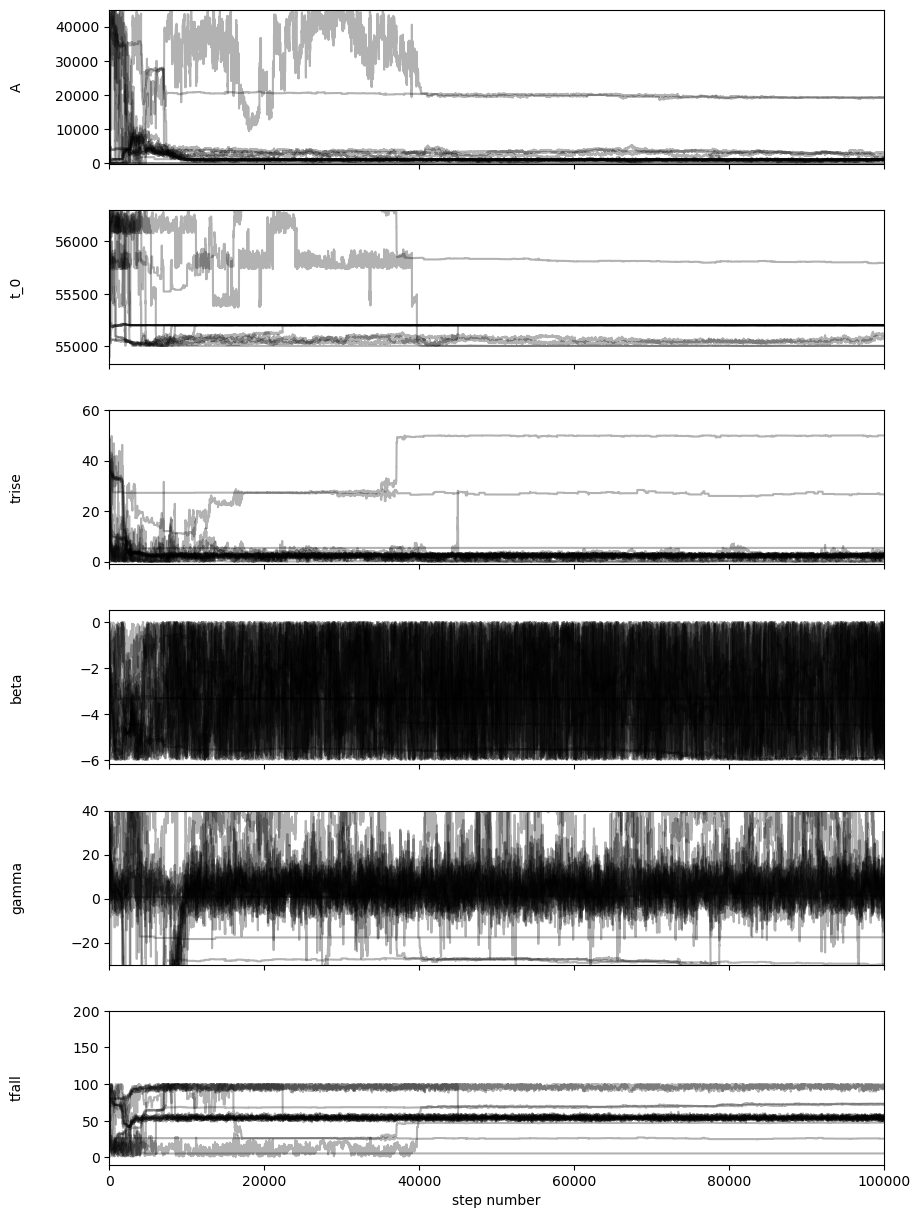

In [19]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples2 = sampler2.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples2[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

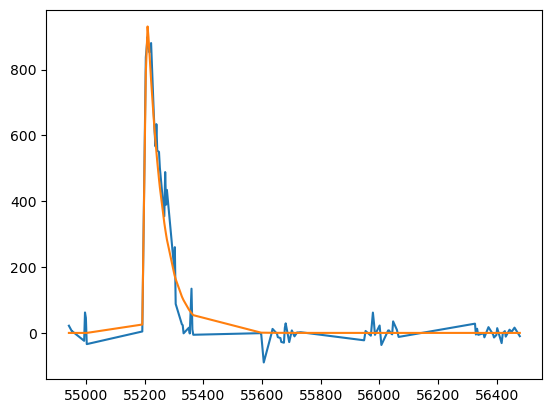

In [20]:
plt.plot(t1r,F1r)
plt.plot(t1r,model(theta2,t1r))

In [21]:
flat_samples2 = sampler2.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples2.shape)


(66660, 6)


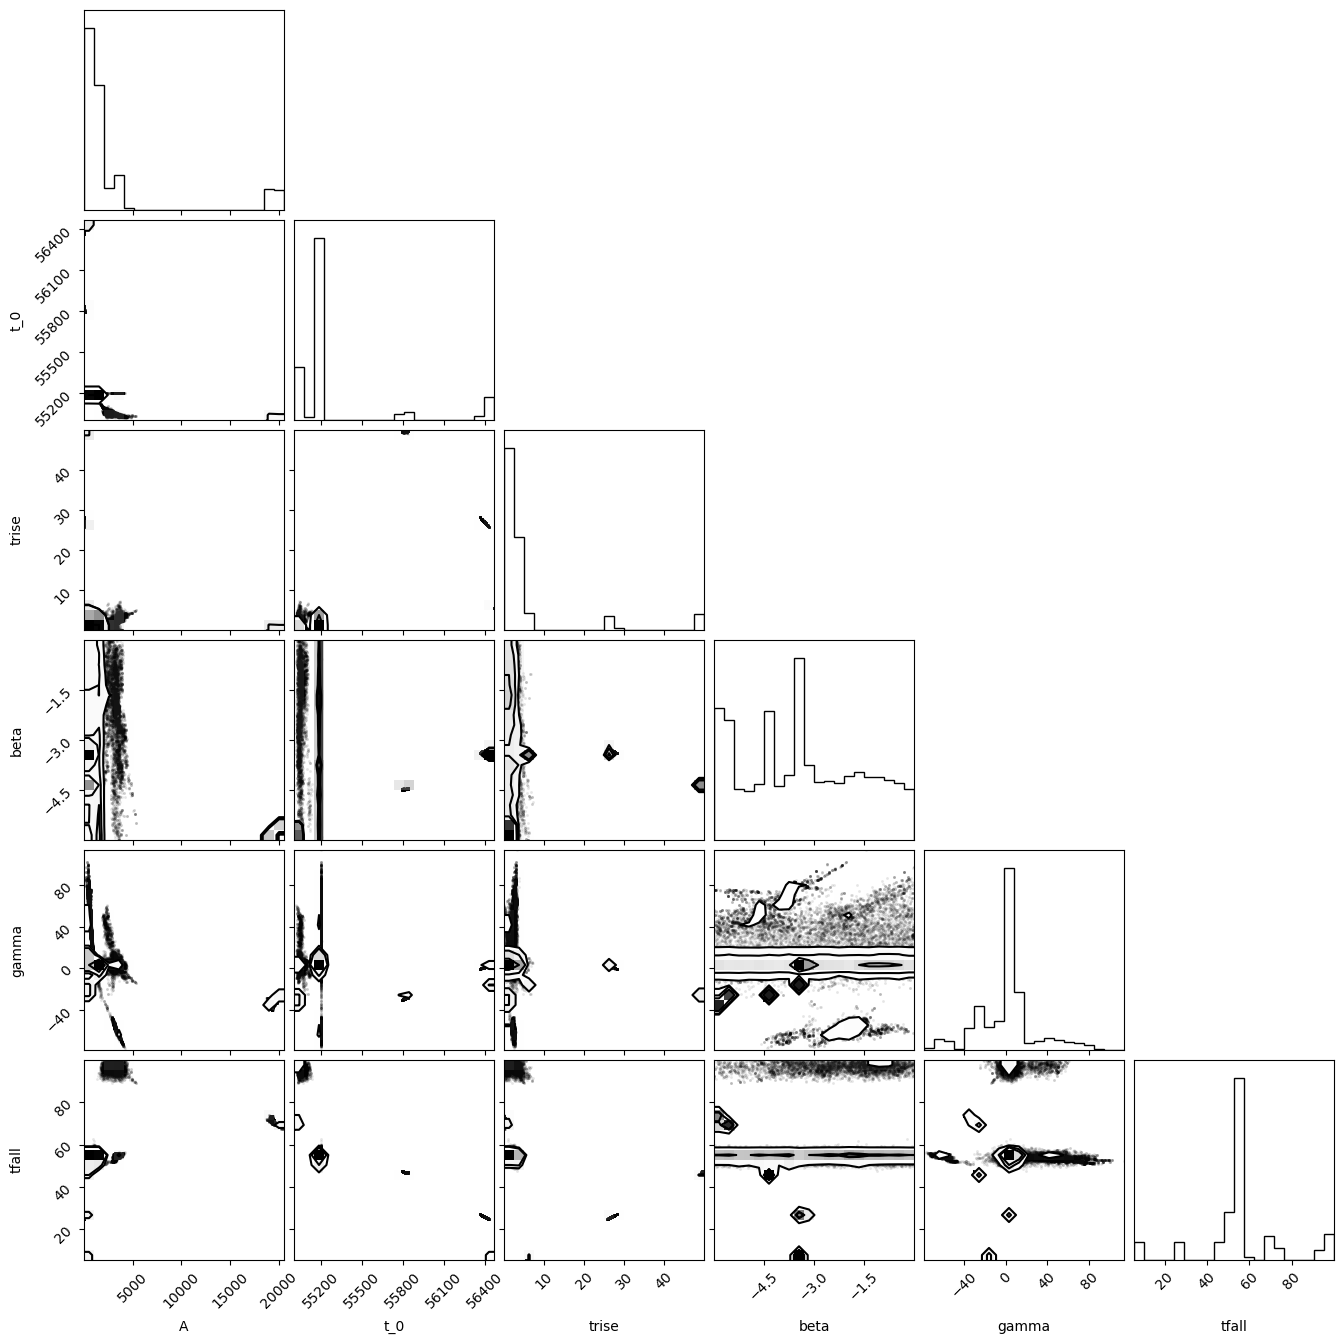

In [22]:
import corner

fig = corner.corner(flat_samples2, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000098, Filter I

In [23]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F1i)
tmin = min(t1i)
tmax = max(t1i)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t1i, F1i, Ferr1i,Fmax,tmin,tmax])
_ =  sampler3.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [24]:
sample3 = sampler3.chain  # shape = (nwalkers, nsteps, ndim)
sample3 = sampler3.chain[:, nburn:, :].reshape(-1, ndim)

In [25]:
theta3 = np.median(sample3,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2878942954.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


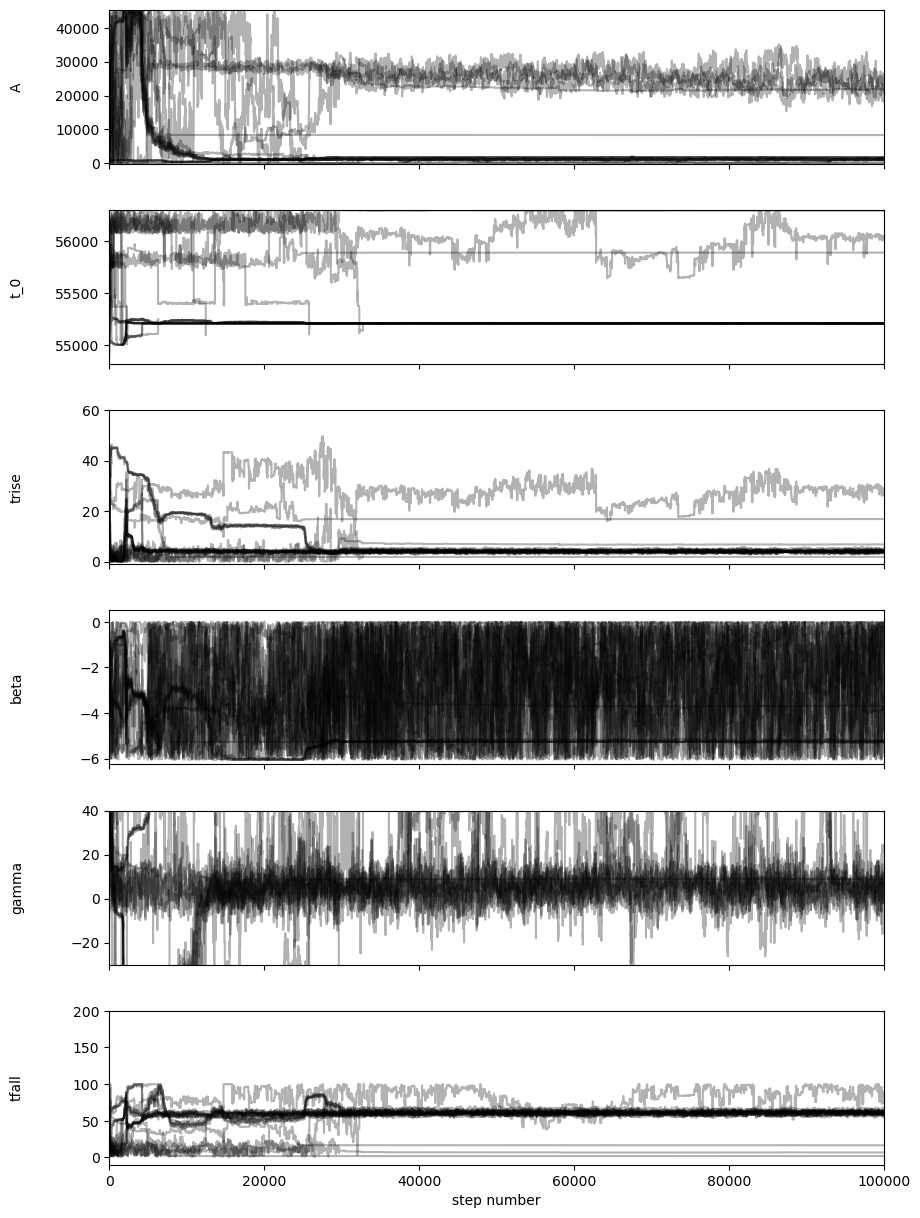

In [26]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples3 = sampler3.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples3[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

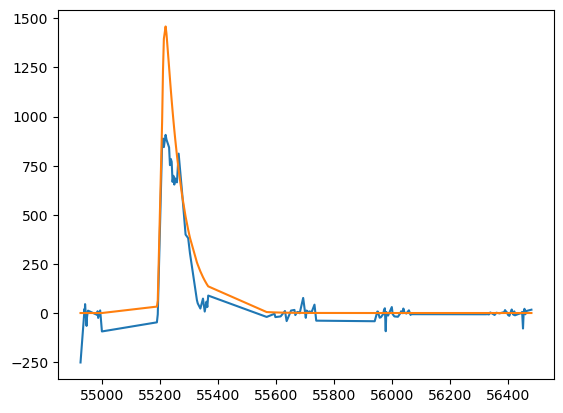

In [35]:
plt.plot(t1i,F1i)
plt.plot(t1i,model(theta3,t1i))

In [29]:
flat_samples3 = sampler3.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples3.shape)


(66660, 6)


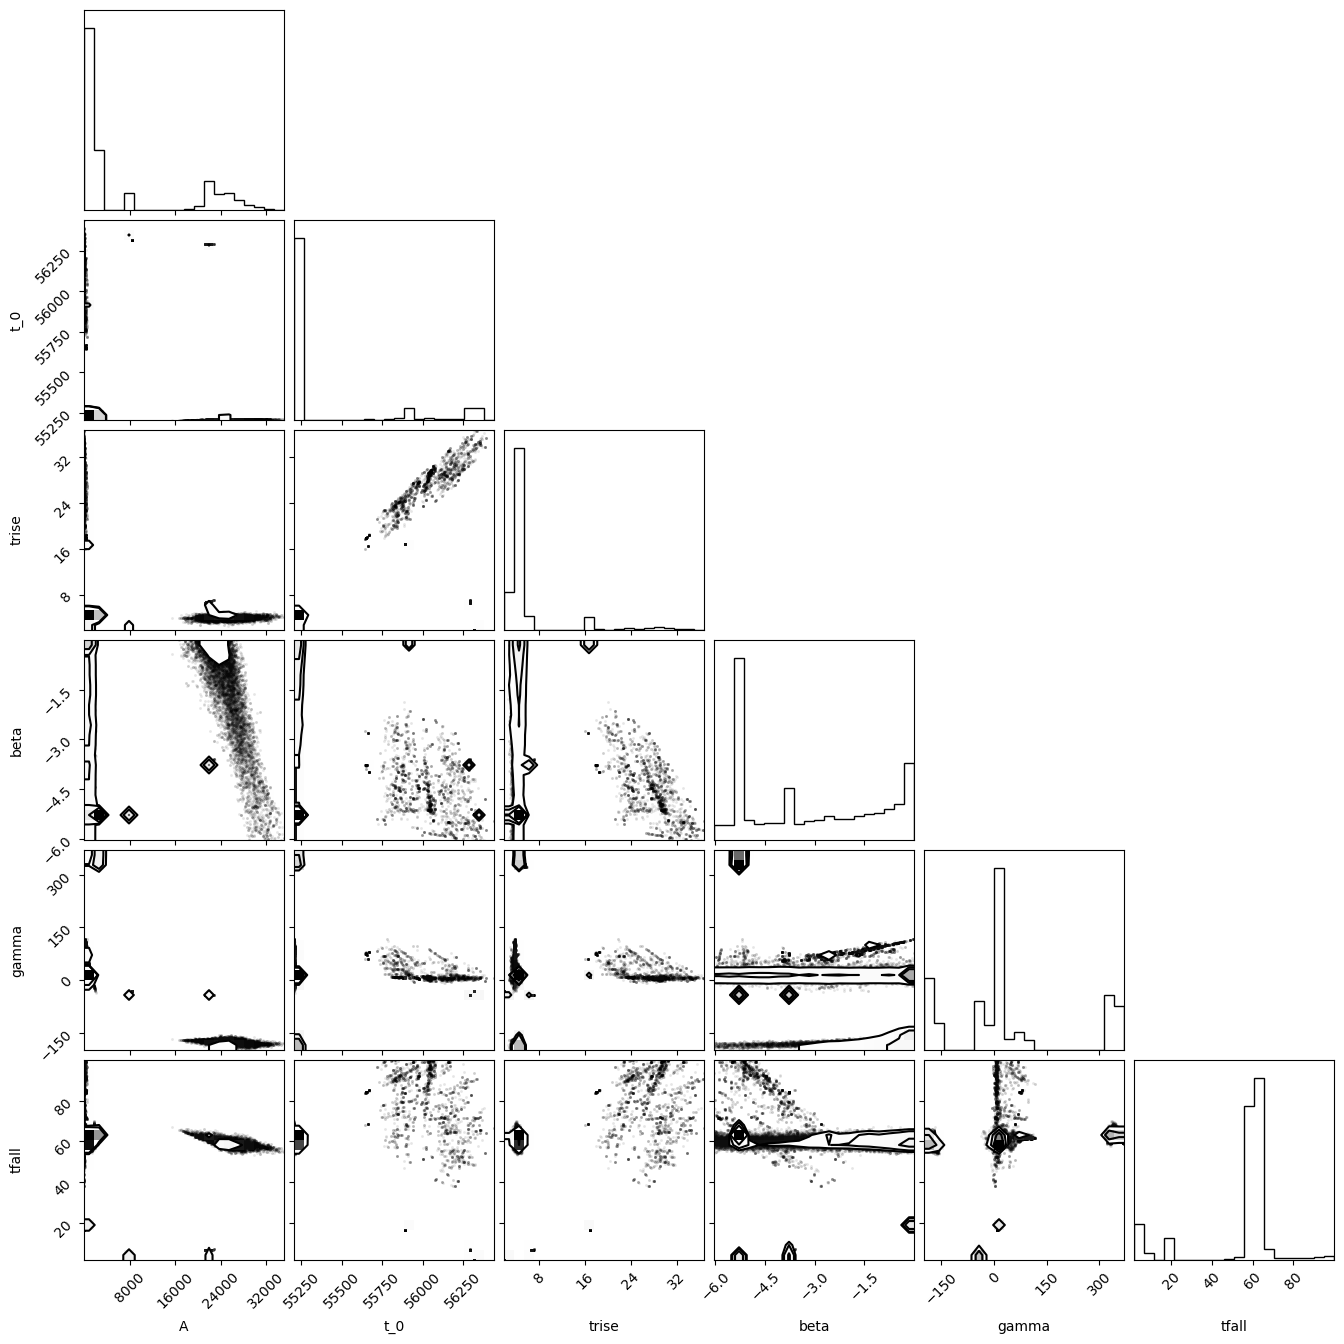

In [30]:
import corner

fig = corner.corner(flat_samples3, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000098, Filter Z

In [31]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F1z)
tmin = min(t1z)
tmax = max(t1z)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler4 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t1z, F1z, Ferr1z,Fmax,tmin,tmax])
_ =  sampler4.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [32]:
sample4 = sampler4.chain  # shape = (nwalkers, nsteps, ndim)
sample4 = sampler4.chain[:, nburn:, :].reshape(-1, ndim)

In [33]:
theta4 = np.median(sample4,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2170370187.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


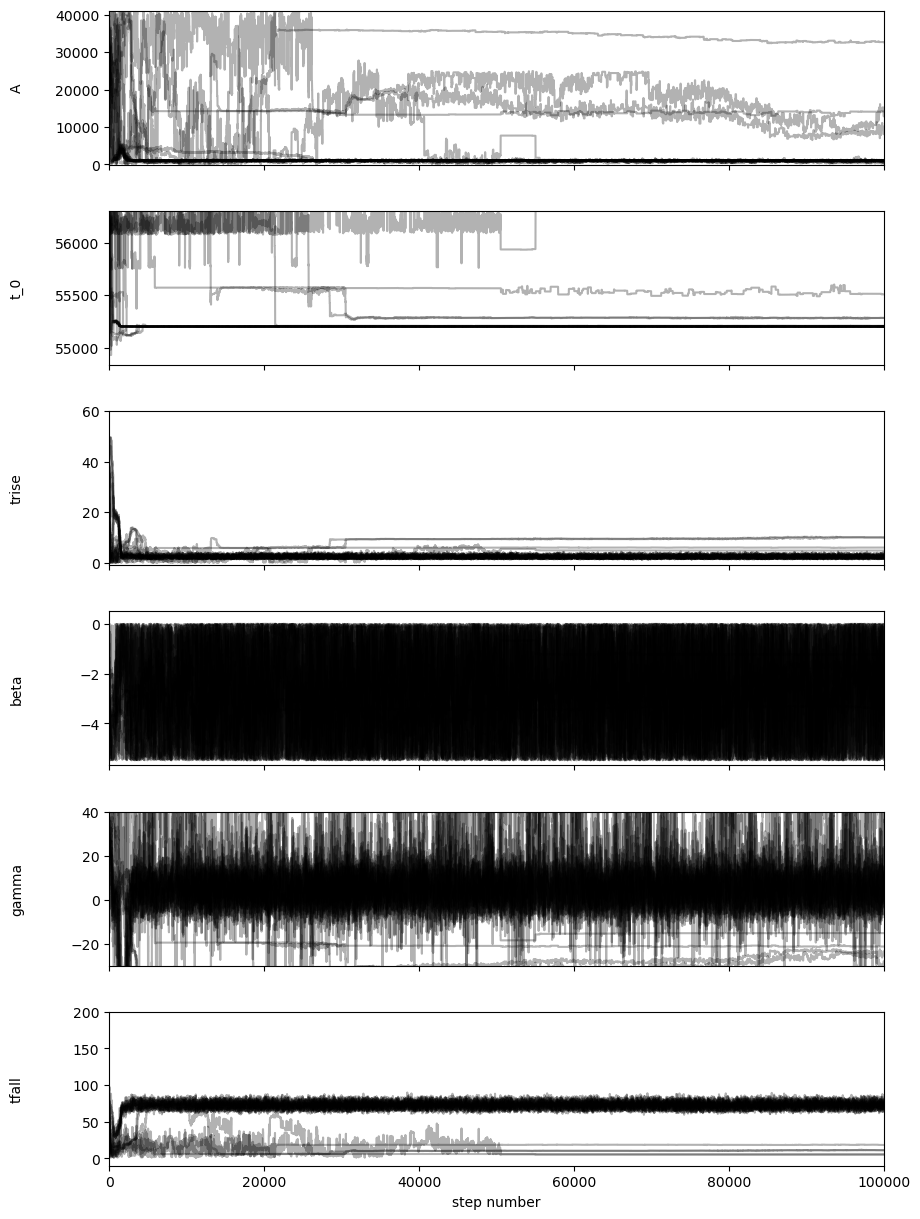

In [34]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples4 = sampler4.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples4[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

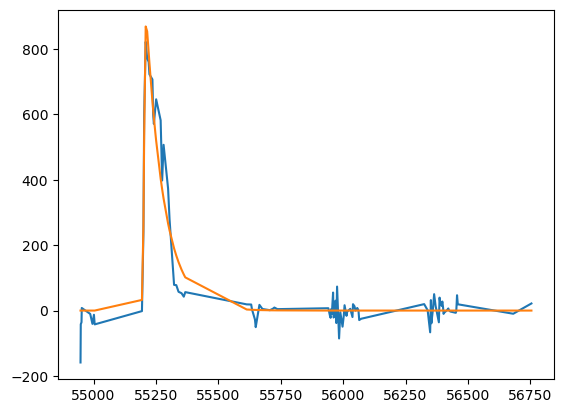

In [36]:
plt.plot(t1z,F1z)
plt.plot(t1z,model(theta4,t1z))

In [37]:
flat_samples4 = sampler4.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples4.shape)


(66660, 6)


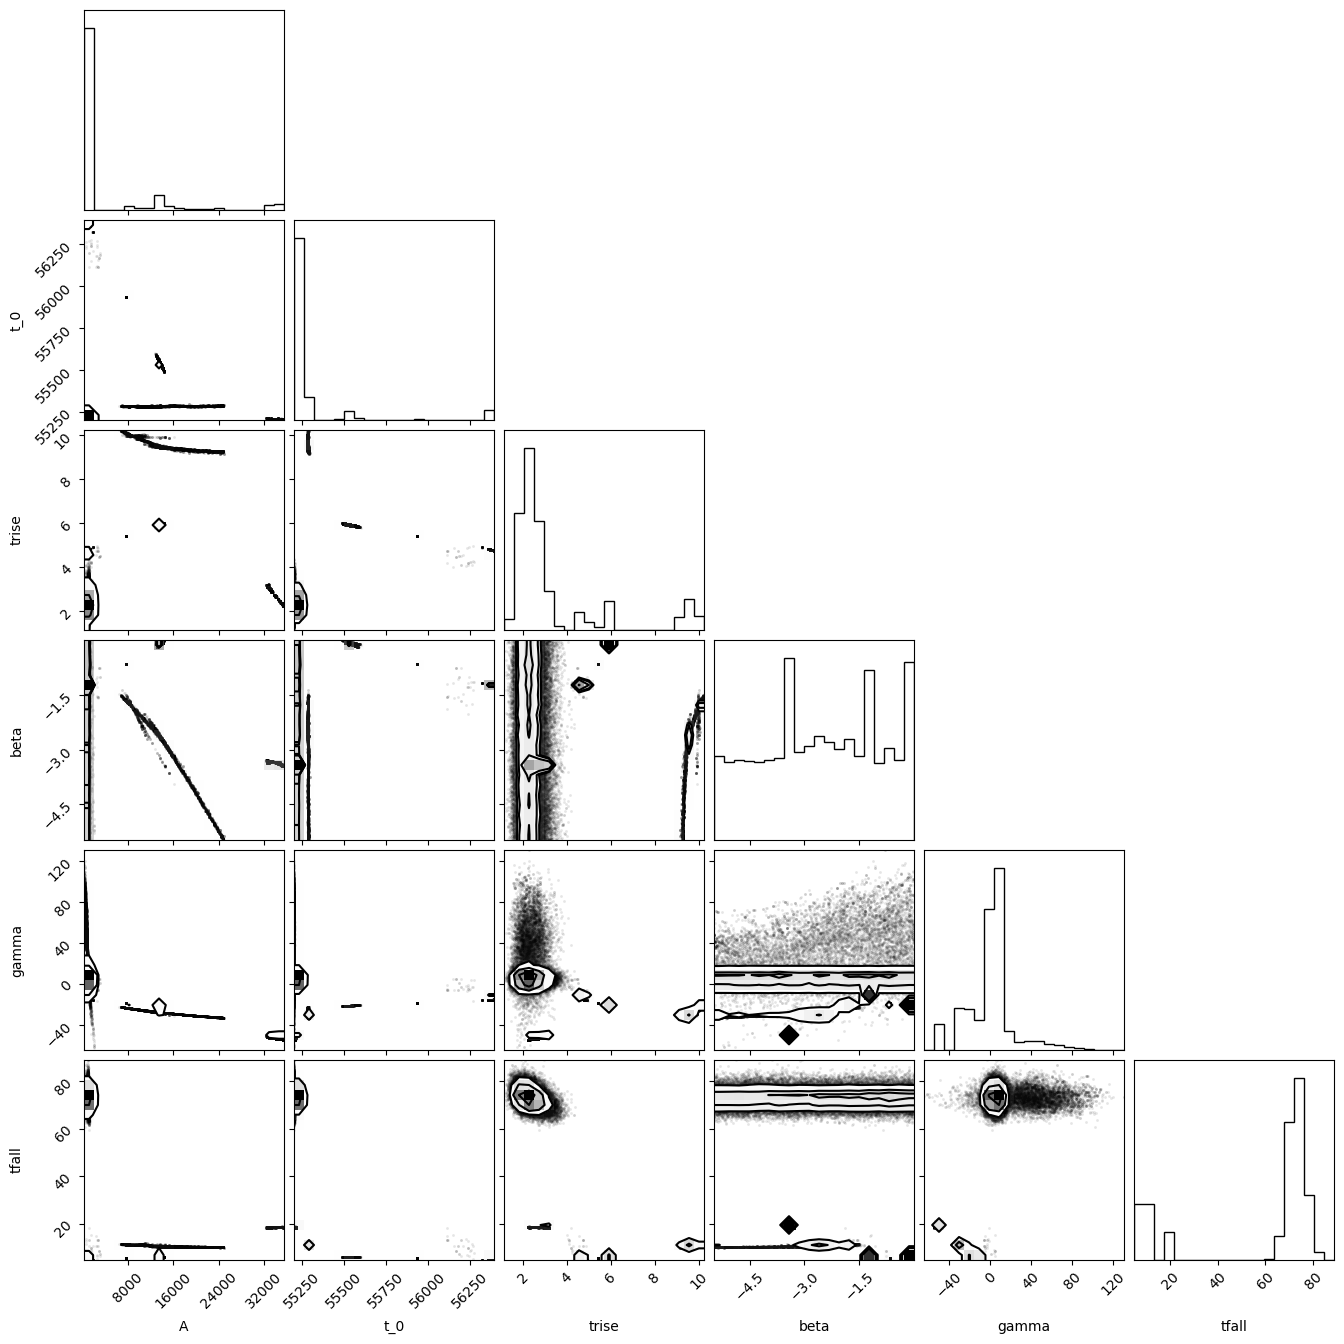

In [38]:
import corner

fig = corner.corner(flat_samples4, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000174, Filter G

In [41]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F2g)
tmin = min(t2g)
tmax = max(t2g)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler5 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t2g, F2g, Ferr2g,Fmax,tmin,tmax])
_ =  sampler5.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [42]:
sample5 = sampler5.chain  # shape = (nwalkers, nsteps, ndim)
sample5 = sampler5.chain[:, nburn:, :].reshape(-1, ndim)

In [43]:
theta5 = np.median(sample5,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/1035904993.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


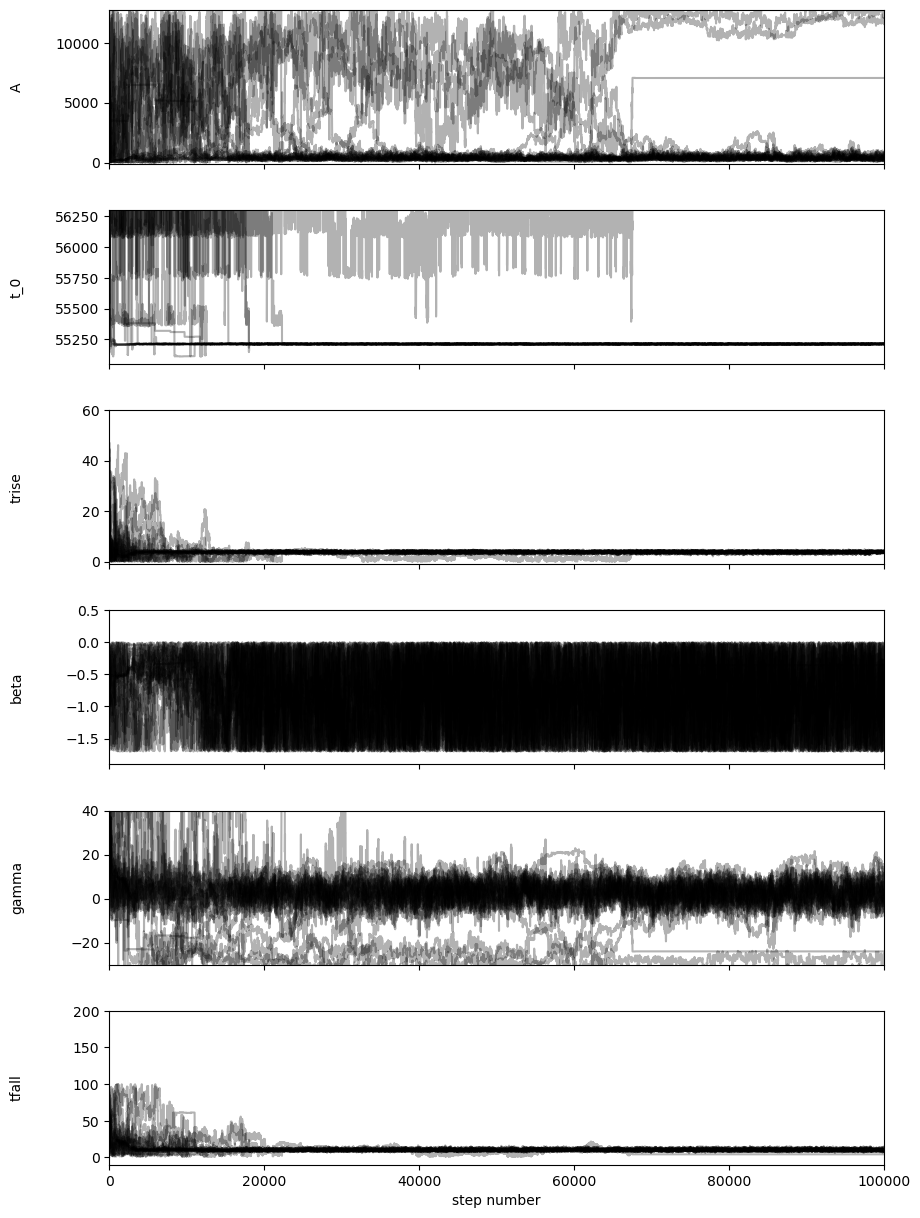

In [44]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples5 = sampler5.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples5[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

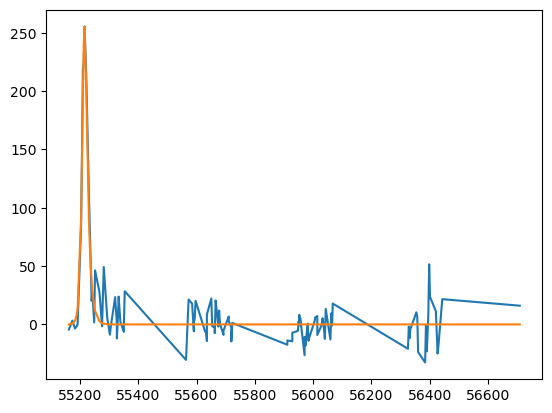

In [45]:
plt.plot(t2g,F2g)
plt.plot(t2g,model(theta5,t2g))

In [46]:
flat_samples5 = sampler5.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples5.shape)


(66660, 6)


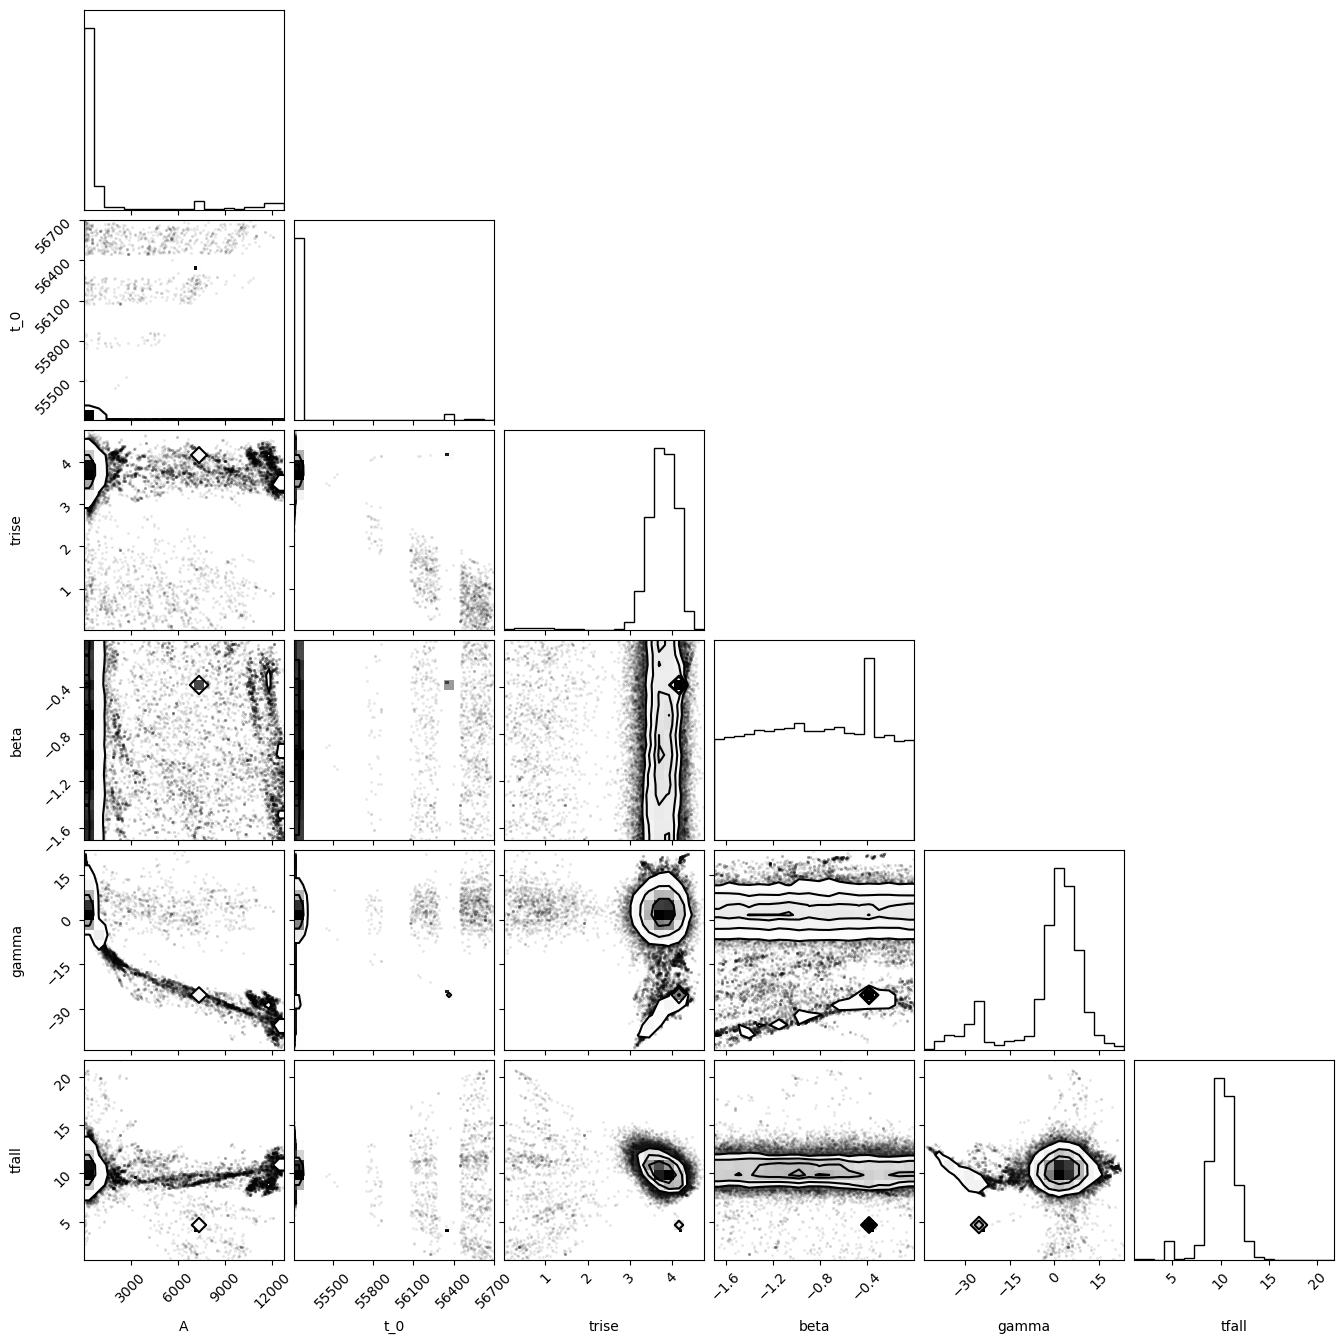

In [47]:
import corner

fig = corner.corner(flat_samples5, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000174, Filter R

In [48]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F2r)
tmin = min(t2r)
tmax = max(t2r)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler6 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t2r, F2r, Ferr2r,Fmax,tmin,tmax])
_ =  sampler6.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [49]:
sample6 = sampler6.chain  # shape = (nwalkers, nsteps, ndim)
sample6 = sampler6.chain[:, nburn:, :].reshape(-1, ndim)

In [50]:
theta6 = np.median(sample6,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/1026893503.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


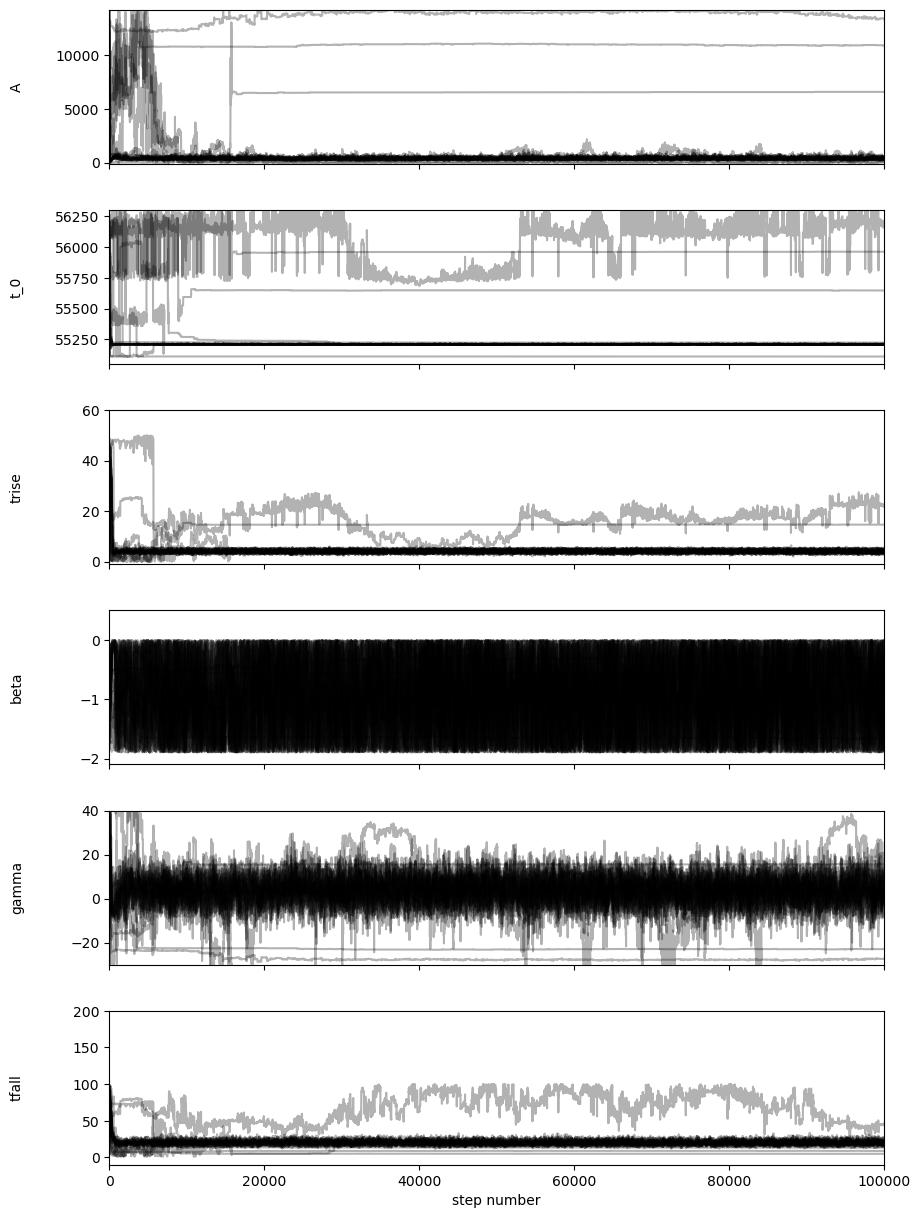

In [51]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples6 = sampler6.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples6[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

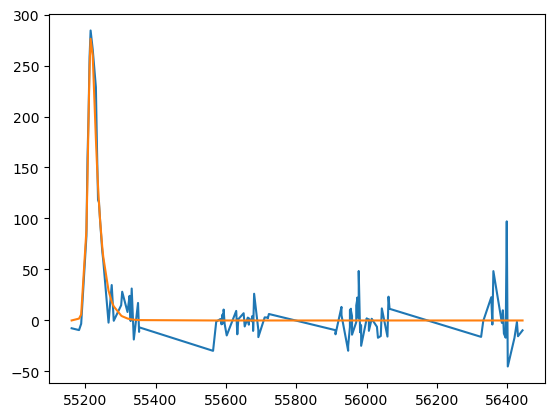

In [52]:
plt.plot(t2r,F2r)
plt.plot(t2r,model(theta6,t2r))

In [53]:
flat_samples6 = sampler6.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples6.shape)


(66660, 6)


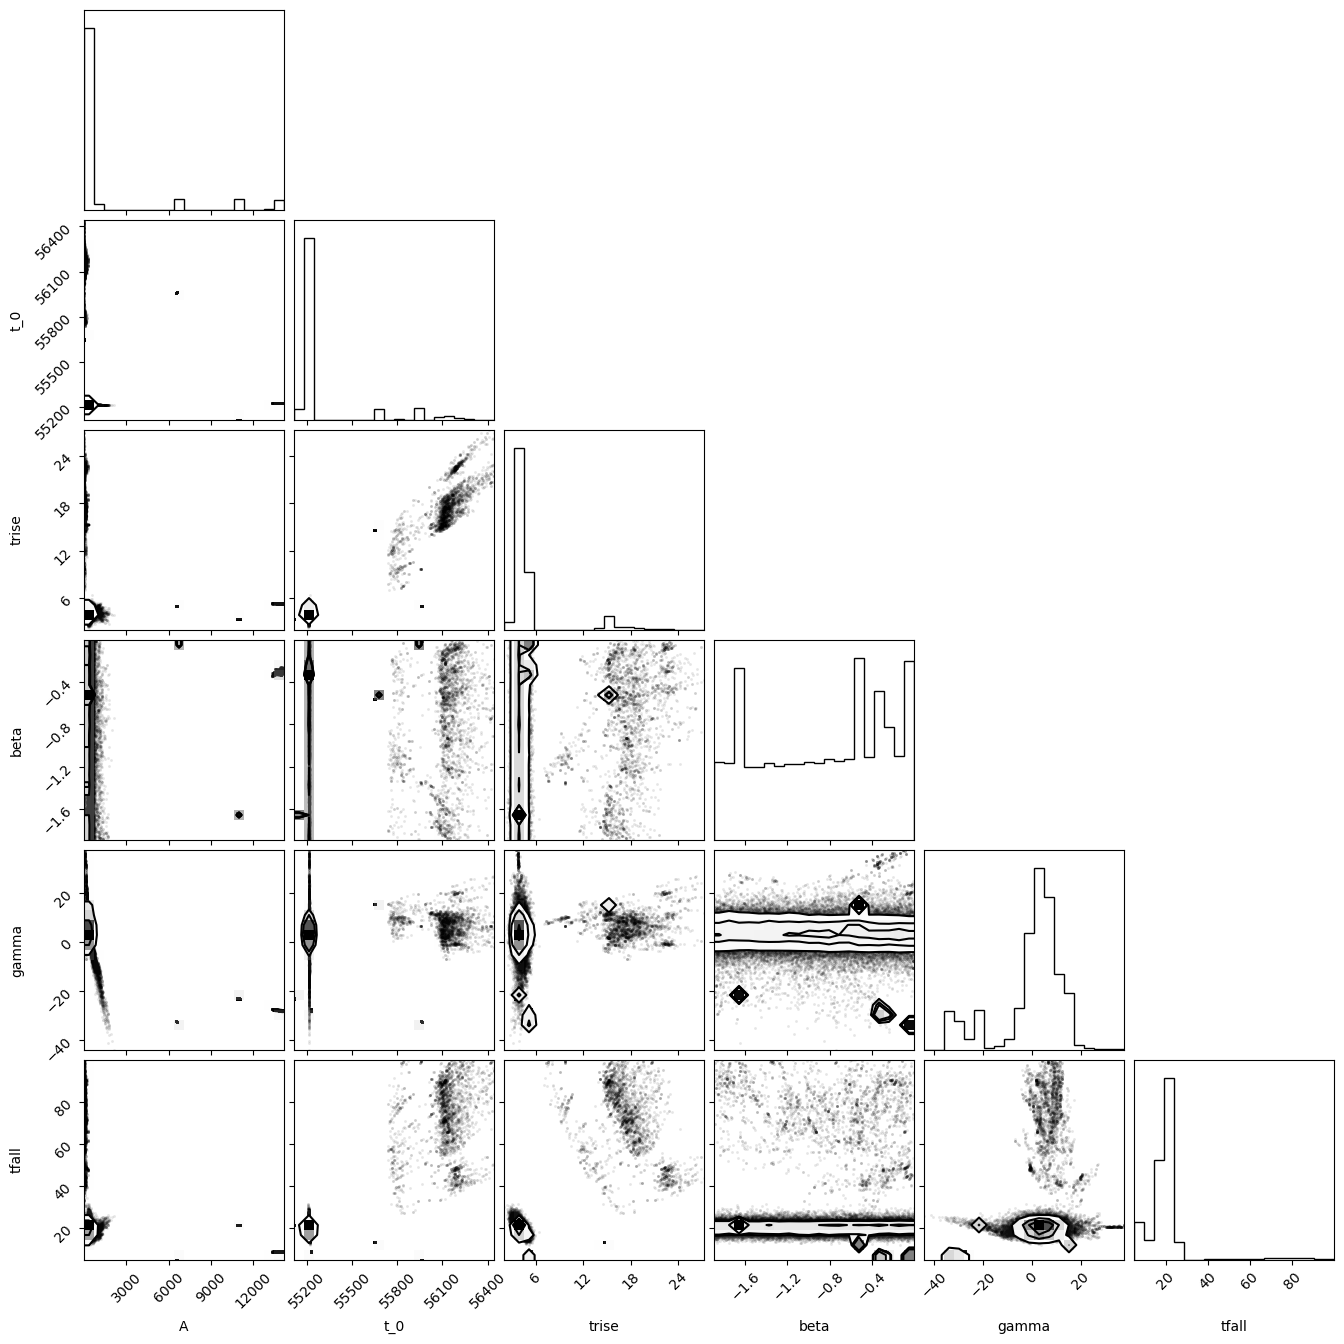

In [54]:
import corner

fig = corner.corner(flat_samples6, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000174, Filter I

In [55]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F2i)
tmin = min(t2i)
tmax = max(t2i)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler7 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t2i, F2i, Ferr2i,Fmax,tmin,tmax])
_ =  sampler7.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [56]:
sample7 = sampler7.chain  # shape = (nwalkers, nsteps, ndim)
sample7 = sampler7.chain[:, nburn:, :].reshape(-1, ndim)

In [57]:
theta7 = np.median(sample7,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/1219368916.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


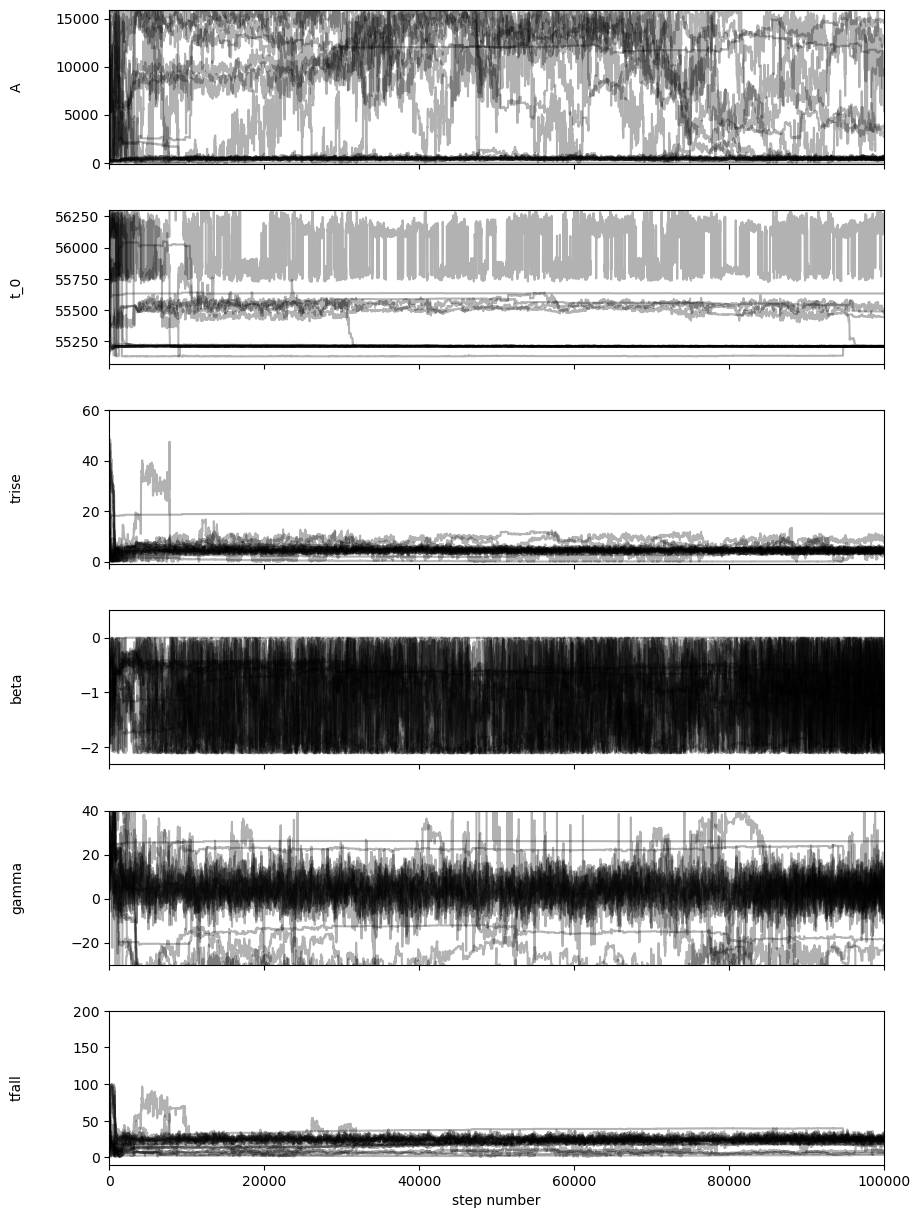

In [58]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples7 = sampler7.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples7[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

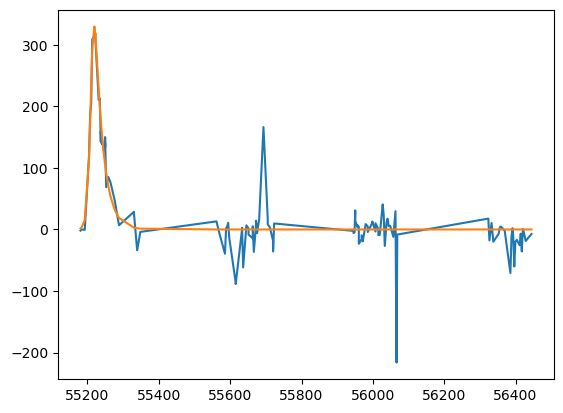

In [59]:
plt.plot(t2i,F2i)
plt.plot(t2i,model(theta7,t2i))

In [62]:
flat_samples7 = sampler7.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples7.shape)


(66660, 6)


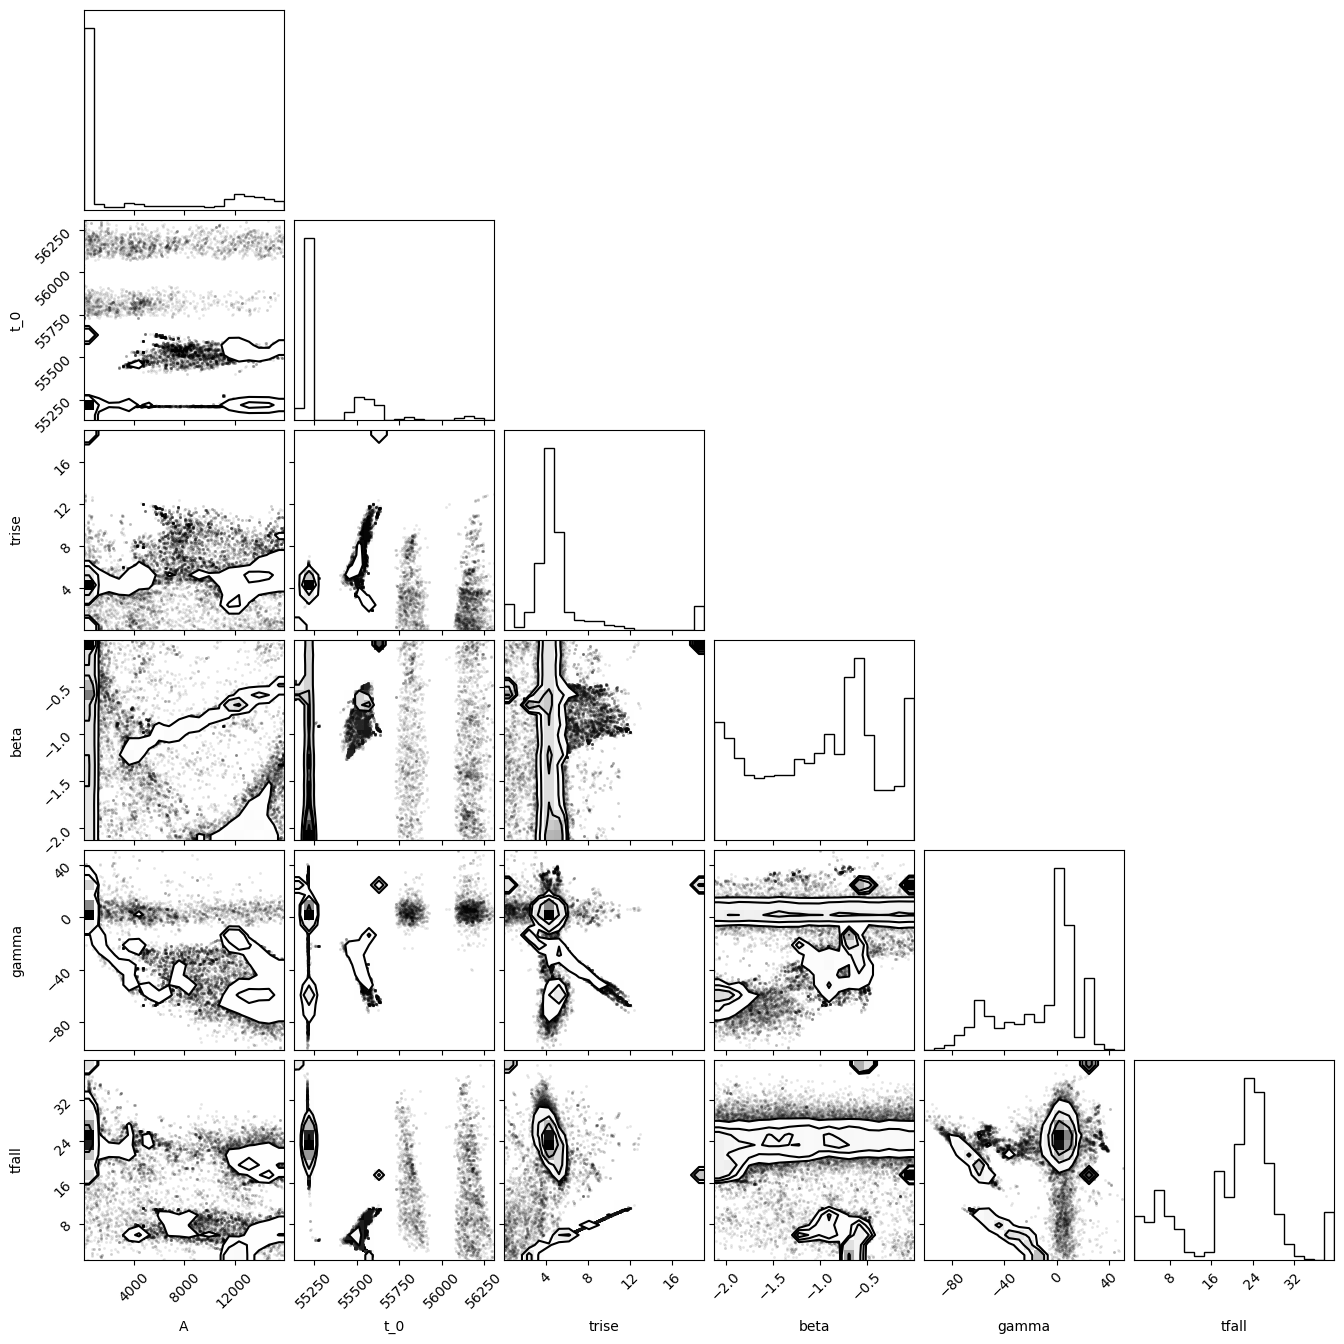

In [63]:
import corner

fig = corner.corner(flat_samples7, labels=labels,plot_contours=True);

# PS1_PS1MD_PSc000174, Filter Z

In [64]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 50000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take

Fmax = max(F2z)
tmin = min(t2z)
tmax = max(t2z)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)

sampler8 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t2z, F2z, Ferr2z,Fmax,tmin,tmax])
_ =  sampler8.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/2483294894.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [65]:
sample8 = sampler8.chain  # shape = (nwalkers, nsteps, ndim)
sample8 = sampler8.chain[:, nburn:, :].reshape(-1, ndim)

In [66]:
theta8 = np.median(sample8,0)

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_64138/1130528459.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


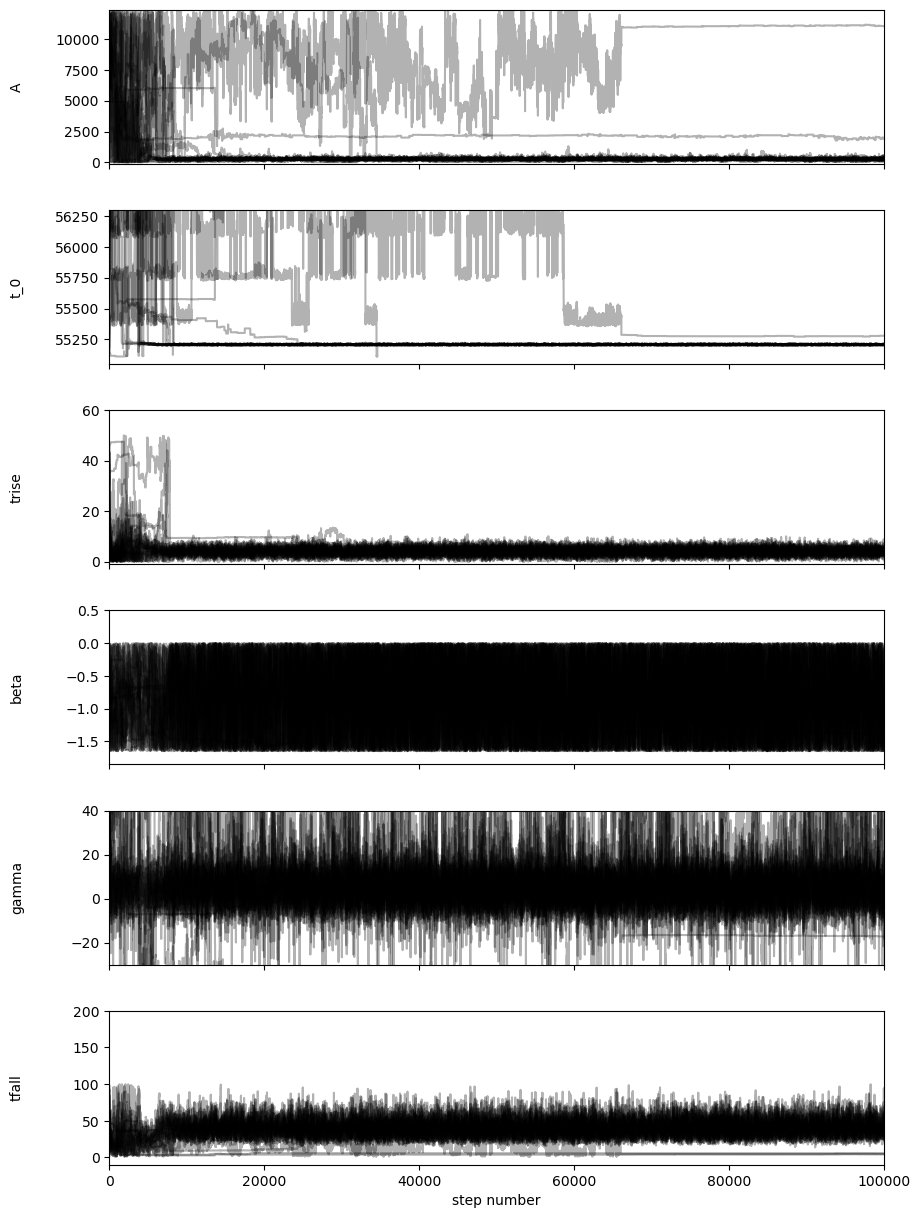

In [67]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples8 = sampler8.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-100,50*Fmax),(tmin-10-100,56300),(-1.01,60),(-.2-Fmax/150,.5),(-30,40),(-10,200)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples8[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,100000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

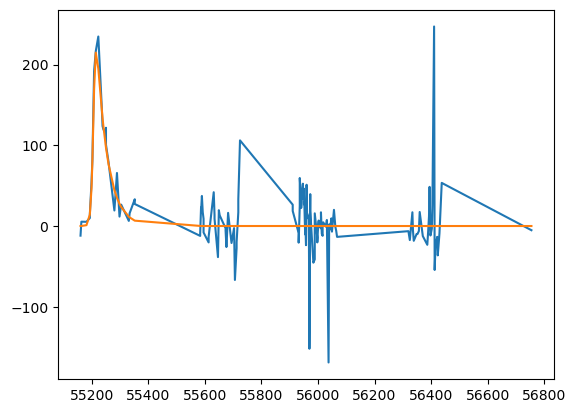

In [68]:
plt.plot(t2z,F2z)
plt.plot(t2z,model(theta8,t2z))

In [69]:
flat_samples8 = sampler8.get_chain(discard=50000, thin=15, flat=True)
print(flat_samples8.shape)


(66660, 6)


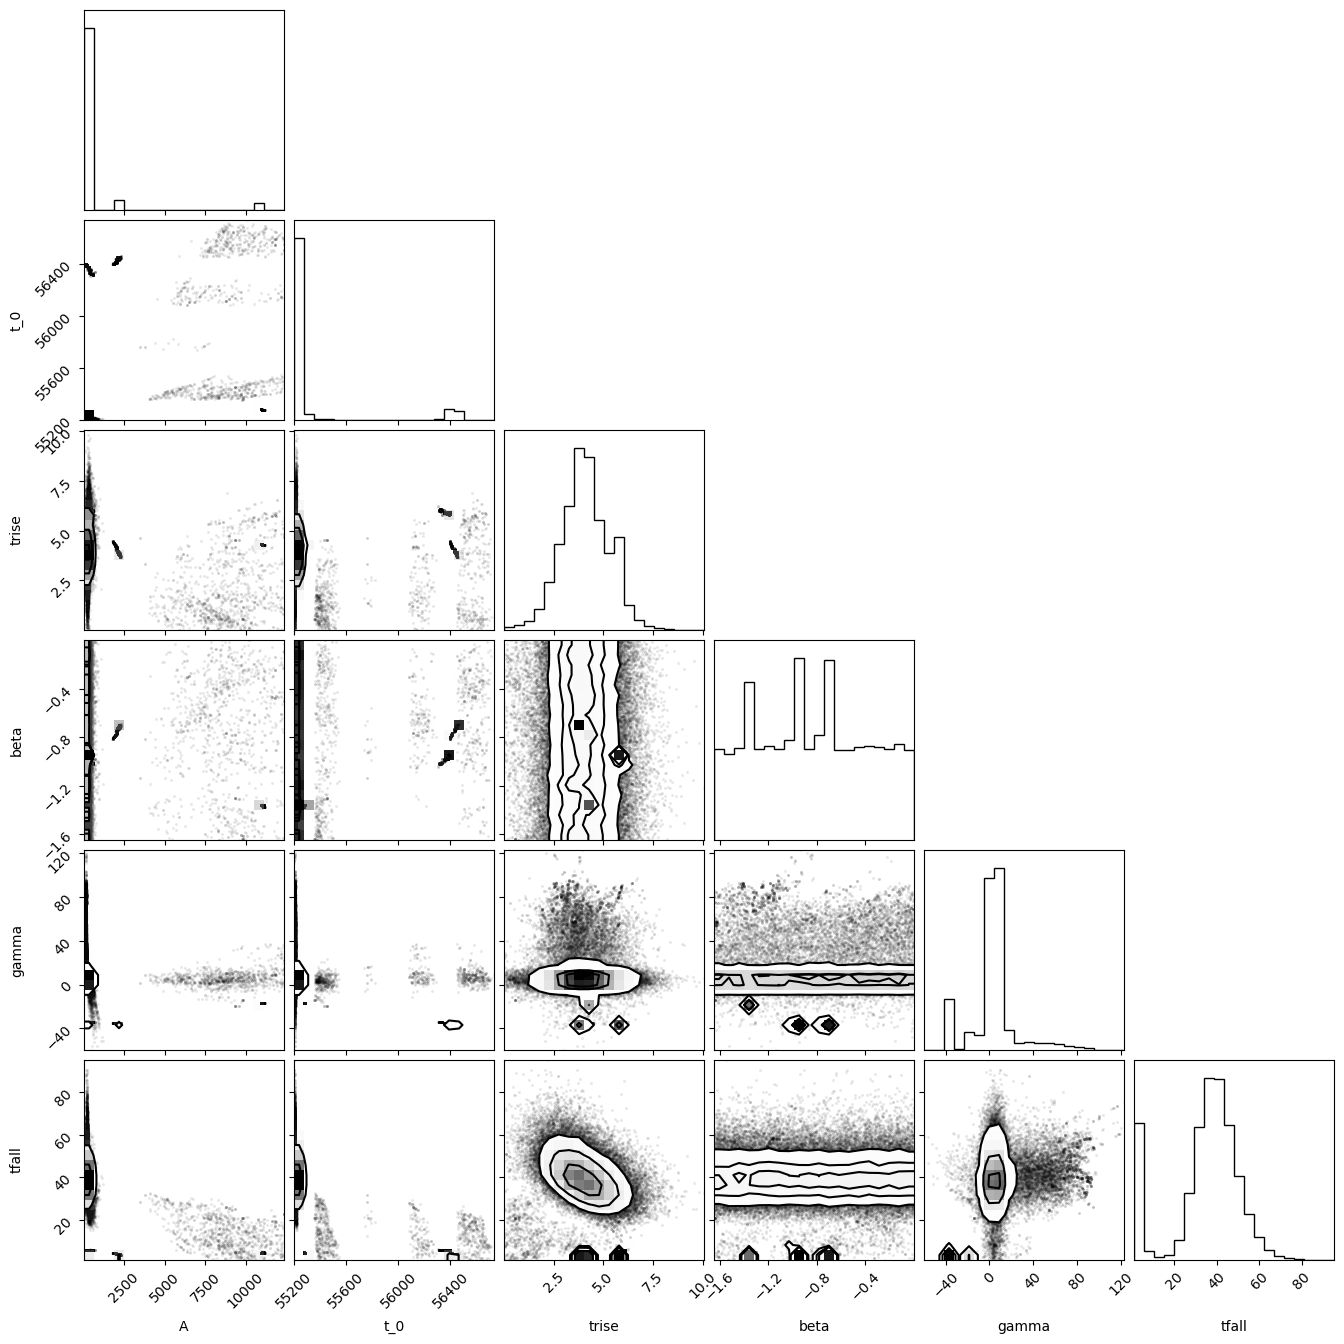

In [70]:
import corner

fig = corner.corner(flat_samples8, labels=labels,plot_contours=True);